In [1]:
import numpy as np
from scipy import interpolate
import time
import math
import matplotlib.pyplot as plt
# from misc.golden_section_search import Search

In [2]:
"""
Michael Pham
November 2024

much thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational
Methods and Applications, Algorithm 10.1.1

third iteration, version 2 with K, Z, and L as state variable
no consumption tax, no human capital investment structure
"""

'\nMichael Pham\nNovember 2024\n\nmuch thanks, heavy inspiration from Prof. Heer from Ch. 10.1.2 in Heer/Maussner, Dynamic General Equilibrium Modeling: Computational\nMethods and Applications, Algorithm 10.1.1\n\nthird iteration, version 2 with K, Z, and L as state variable\nno consumption tax, no human capital investment structure\n'

In [3]:
exp = np.e
log = math.log

In [4]:
# Parameters - households and firms
beta = 0.935  # discount factor
eta = 0.75    # coefficient of relative risk aversion
gamma = 1 #labor disutility scaling parameter
chi = 0.75 # curvature of preferences over leisure
alpha = 0.33 # capital share in production
delta = 0.1  # depreciation rate
# omega = 0.1  # parent education time factor
# phi_p = 0.5  # share of parental input in education
# psi_e = 0.5  # CES parameter for education inputs
# theta_I = 0.7  # human capital investment effectiveness
tfp = 1      #total factor productivity
small = 0.00001
neg = -1e10

#Parameters - government
tau = 0.15
Ie_gdp = 0.03 # public education investment as percent of GDP
Iz_gdp = 0.06 # public infrastructure investment as percent of GDP percent of GDP
sigma_bar = 0.3  # public investment inefficiency
G_gdp = 0.07      # grants (as a fraction of GDP)
psi = 0.1   # public infrastructure elasticity
# nu = 0.6     # debt-to-GDP ratio limit

# Initial guesses
# K_init = 1
# H_init = 1
# L_init = 0.2
# Z_init = 1
# tau_init = 0.15  # Initial guess for tax rate
# T_init = 0.1  # Initial guess for transfers
# D_init = 0

# Grid spec
na = 50  # number of points in capital grid
nl = 50  # number of points in capital grid

# nH = 20   # number of points in human capital grid
# nZ = 20   # number of points in public infrastructure grid
# Kmin = 0
# Kmax = 10
# Hmin = 0
# Hmax = 10
# Zmin = 0
# Zmax = 10

k_start = 0
k_min, k_max = 0, 4
k_grid =  np.linspace(k_min, k_max, na)   # asset grid 
k_eps = (k_grid[1]-k_grid[0])/na    #  test for corner solution
phi = 0.8           # updating of the aggregate capital stock K in outer loop
tolerance = 0.001        # percentage deviation of final solution 
tolerance_gs = 1e-10       # tolerance for golden section search 
max_iters = 30             # maximum number of iteration over K

l_start = 0
l_min, l_max = 0, 1
l_grid =  np.linspace(l_min, l_max, nl)   # asset grid 



# Number of periods
periods = 40
child_periods = 18

Production Equations

In [5]:
def production(Z_prev, K_prev, H, L):
    """
    production function (eq 1 mod)

    params: K_t-1, H_t, L_t
    returns: Y
    """
    return tfp * Z_prev**psi * K_prev**(alpha-psi) * (H*L)**(1-alpha-psi)

def wage_rate(Z_prev, K_prev, H, L):
    """
    marginal product of labor (eq 2 mod)

    params: K_t-1, H_t, L_t
    returns: w_t
    """
    return tfp * Z_prev**psi * (1-alpha-psi) * (K_prev)**(alpha-psi) * (H*L)**(-alpha-psi)

def interest_rate(Z_prev, K_prev, H, L):
    """
    marginal product of capital minus depreciation (eq 3 mod + interest steady state)

    params: K_t-1, H_t, L_t
    returns: r_t 
    """
    return tfp * (alpha -psi) * Z_prev**psi * (H*L)**(1-alpha-psi) * K_prev**(alpha-1-psi) - delta

Government Equations

In [6]:
def transfer(K_prev, H, L, G, tau, w, r):
  """
  government budget (eq 6 mod)
  assumes balanced budget, no borrowing

  params: K_t-1, H_t, L_t, G, tau, w_t, r_t
  returns: T (transfers)
  """
  tax_revenue = tau*w*H*L + tau*r*K_prev
  total_revenue = tax_revenue + G
  return total_revenue #- Y*Ie_gdp

Household Equations

In [7]:
# def utility(c, l):
#   """
#   household utility function (eq 8)
#   adds modified case of when full labor, so utility is not 0

#   params: c_t, l_t
#   returns: utility
#   """

#   if l == 1:
#     return np.log(c+ small) + gamma * np.log(l)

#   return (((c) * (1-l) ** gamma) ** (1-eta) - 1) / (1-eta)

def utility(c, l):
  # """
  # household utility function (eq 8)
  # adds modified case of when full labor, so utility is not 0

  # params: c_t, l_t
  # returns: utility
  # """

  # if l == 1:
  #   return np.log(c+ small) + gamma * np.log(l)

  return (c**(1-eta))/(1-eta) + gamma*(((1-l)**(1-chi))/(1-chi))



def value_function(next_value_interpolator, k, k_prev, l, h, w, r, tau, T):
  """
  household bellman equation (eq 14)
  
  params: k_t, k_t-1, c_t, l_t, h_t, w_t, r_t, tau, T
  returns: value of this period's bellman equation
  """
  if l < 0: # corner solution 0<=n<=1
    l = 0
  elif l > 1: # corner solution
    l = 1

  c = (1-tau)*w*h*l - k + (1+r)*k_prev - tau*r*max(k_prev, 0) + T
  if c <= 0:
    return neg
  # print(f"in value function, c: {c}, l, {l}, interpolator, {next_value_interpolator}")
  return utility(c, l) + beta * next_value_interpolator(k) # Added l as second argument

def consumption(k_prev, k, h, l, w, r, tau, T):
  return (1-tau)*w*h*l + (1+ r)*k_prev - tau*r*max(k_prev, 0) + T - k


In [8]:
#initialize steady state variable predictions
h_init = 1
l_init = 0.3
r_init = beta**(-1) - 1

Z_bar = 0.1
L_bar = l_init #refers to guess of L in this period
H_bar = h_init #refers to guess of H in this period
# K_bar = ((r_init + delta)/(alpha*tfp))**(1/(alpha-1)) * (H_bar * L_bar) #new guess!
K_bar = 0.4
L_old = L_bar + 2
H_old = H_bar + 100
K_old = K_bar + 100
Z_old = Z_bar + 100

h = 1
l = l_init

K_bar

0.4

In [9]:
class Search:
  
  def __init__(self, next_value_interpolator, function, left, initial_guess, right, tolerance, k_prev, l, h, w, r, tau, T) -> None:
    self.next_value_interpolator = next_value_interpolator
    self.function = function
    self.left = left
    self.right = right
    self.initial_guess = initial_guess
    self.tolerance = tolerance
    self.k_prev = k_prev
    self.l = l
    self.h = h
    self.w = w
    self.r = r
    self.tau = tau
    self.T = T

  def evaluate_function(self, k):
    return self.function(self.next_value_interpolator, k, self.k_prev, self.l, self.h, self.w, self.r, self.tau, self.T)

  def find_max(self):
    golden_ratio = ((1+np.sqrt(5))/2)
    golden_ratio_dec = golden_ratio - 1

    if abs(self.right - self.initial_guess) >= abs(self.initial_guess - self.left):
      golden_left = self.initial_guess
      golden_right = self.initial_guess + (1 - golden_ratio_dec) * (self.right - self.initial_guess)
    else:
      golden_right = self.initial_guess
      golden_left = self.initial_guess - (1 - golden_ratio_dec) * (self.initial_guess - self.left)

    while (self.right - self.left) > self.tolerance:
      if self.evaluate_function(golden_left) < self.evaluate_function(golden_right):
        self.left = golden_left
      elif self.evaluate_function(golden_left) > self.evaluate_function(golden_right):
        self.right = golden_right
      elif self.evaluate_function(golden_left) == self.evaluate_function(golden_right):
        self.left = golden_left
        self.right = golden_right

      golden_left = self.left + (1 - golden_ratio_dec) * (self.right-self.left)
      golden_right = self.left + (golden_ratio_dec) * (self.right-self.left)
    
    return self.left if self.evaluate_function(self.left) > self.evaluate_function(self.right) else self.right

iter: 0; K change: 250.00; H change: 100.00; L change: 6.67; Z change: 1000.00
tax_revenue: 0.03286996586522332
grants: 0.022674146754713603
T: 0.03610912968732526
iter: 0; K: 0.40; H: 1.00; L: 0.30; Z: 0.10
iter: 0; Y: 0.32; tau: 0.15; T: 0.04
[6.33578972 6.57044132 6.78258724 6.97634889 7.15527904 7.31932353
 7.46304498 7.59081745 7.7062446  7.81179533 7.90924147 7.99990141
 8.08478492 8.16468404 8.24023246 8.3119458  8.3802497  8.44549994
 8.50799727 8.56799833 8.62572406 8.68136615 8.73509207 8.78704905
 8.83736732 8.88616261 8.93353833 8.97958726 9.02439298 9.06803111
 9.11057026 9.15207292 9.19259617 9.2321923  9.27090933 9.30879152
 9.34587968 9.3822116  9.41782231 9.45274436 9.48700803 9.5206416
 9.55367144 9.58612225 9.61801718 9.64937796 9.68022499 9.71057751
 9.74045361 9.7698704 ]
iter: 0, i: 39, k: 0.4, l: 0.3
k_opt: 0.0, l_opt: 0.4081632653061224, asset: 0.0, value: 12.259753112765159
k_opt: 0.08163265306122448, l_opt: 0.4081632653061224, asset: 0.08163265306122448, value

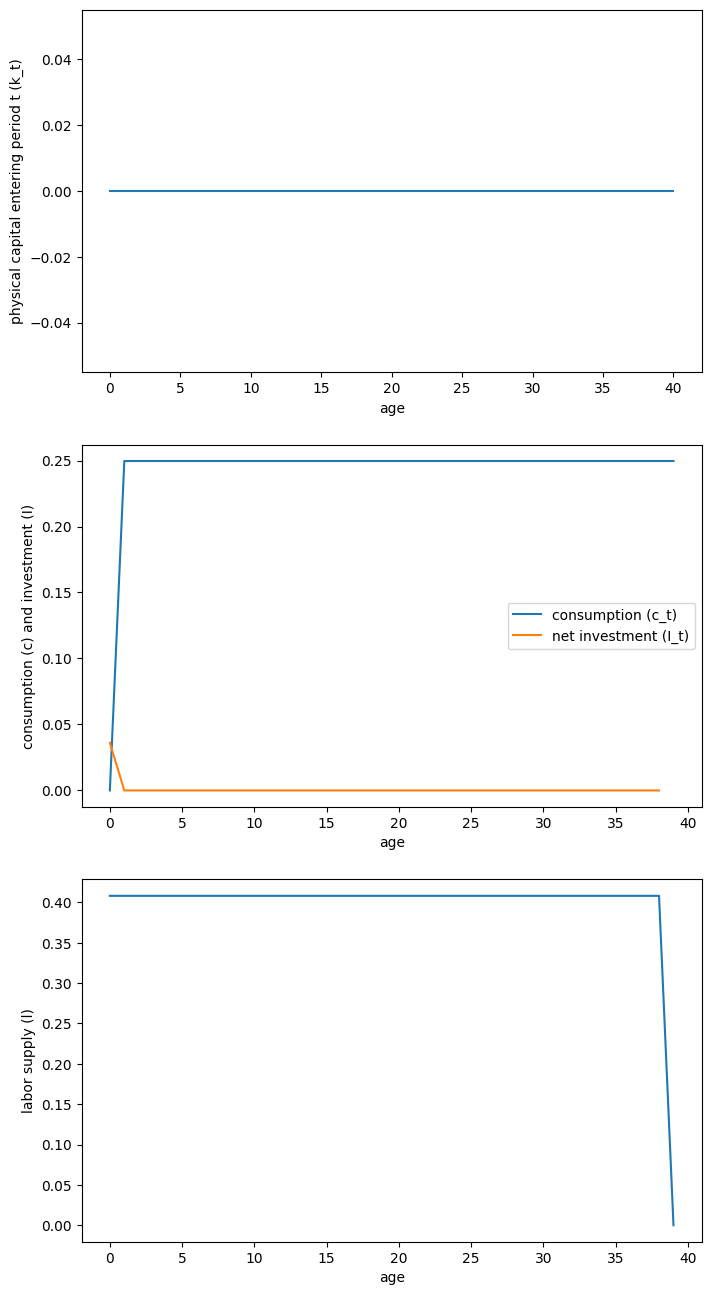

iter: 1; K change: 0.25; H change: 0.00; L change: 0.06; Z change: 0.03
tax_revenue: 0.0336169722811304
grants: 0.022409900497326073
T: 0.03681838663789127
iter: 1; K: 0.32; H: 1.00; L: 0.32; Z: 0.10
iter: 1; Y: 0.32; tau: 0.15; T: 0.04
[6.29319814 6.55031729 6.78025422 6.98890152 7.18000646 7.34684321
 7.49190751 7.62085942 7.73734236 7.84385169 7.9421778  8.03365258
 8.11929604 8.19990811 8.27612875 8.34847861 8.41738744 8.48321448
 8.54626333 8.60679307 8.66502674 8.72115782 8.77535536 8.82776797
 8.87852707 8.92774948 8.97553956 9.02199094 9.06718798 9.11120699
 9.15411719 9.19598167 9.236858   9.27679897 9.31585303 9.35406482
 9.39147555 9.42812334 9.46404353 9.49926897 9.53383021 9.56775578
 9.60107229 9.63380467 9.66597627 9.697609   9.72872348 9.75933908
 9.78947408 9.81914572]
iter: 1, i: 39, k: 0.32000000000000006, l: 0.3195918367346938
k_opt: 0.0, l_opt: 0.3877551020408163, asset: 0.0, value: 12.177338399484192
k_opt: 0.08163265306122448, l_opt: 0.3877551020408163, asset: 0.

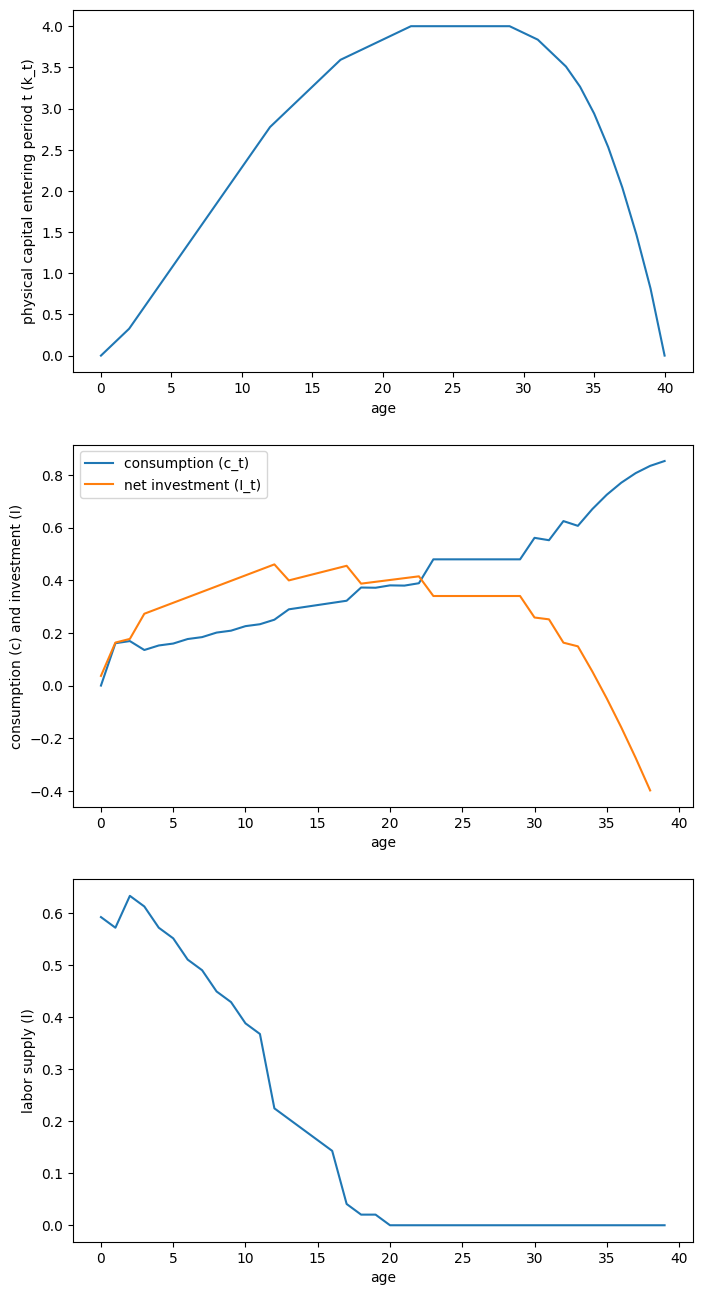

iter: 2; K change: 0.60; H change: 0.00; L change: 0.10; Z change: 0.03
tax_revenue: 0.03313837998652583
grants: 0.02632786451594959
T: 0.036899503488804344
iter: 2; K: 0.80; H: 1.00; L: 0.29; Z: 0.11
iter: 2; Y: 0.38; tau: 0.15; T: 0.04
[6.44992584 6.64128475 6.81766722 6.98113483 7.13400299 7.27753134
 7.41310257 7.53835144 7.65155608 7.75511504 7.85075225 7.93975192
 8.02309864 8.10156528 8.17577061 8.2462184  8.31332471 8.37743748
 8.43885091 8.49781615 8.55454951 8.60923866 8.66204763 8.71312066
 8.76258534 8.81055511 8.8571313  8.90240489 8.94645782 8.98936424
 9.03119144 9.07200071 9.11184805 9.15078475 9.18885794 9.22611103
 9.26258409 9.29831418 9.33333571 9.36768061 9.40137861 9.43445747
 9.46694308 9.49885969 9.53023003 9.56107543 9.59141594 9.62127043
 9.65065669 9.67959151]
iter: 2, i: 39, k: 0.799673469387755, l: 0.2914897959183673
k_opt: 0.0, l_opt: 0.42857142857142855, asset: 0.0, value: 12.48060650552073
k_opt: 0.0, l_opt: 0.36734693877551017, asset: 0.0816326530612244

In [10]:
from scipy.optimize import minimize


iteration = -1
K_diff = 1 + tolerance
state_var_iter_array = np.zeros((max_iters,4))

#loop while max_iters not exceeded and difference between this K guess and previous K guess is greater than acceptable tolerance
while iteration < max_iters - 1 and K_diff > tolerance:
  iteration += 1
  K_diff = abs((K_bar - K_old) / K_bar)
  H_diff = abs((H_bar - H_old) / H_bar)
  L_diff = abs((L_bar - L_old) / L_bar)
  Z_diff = abs((Z_bar - Z_old) / Z_bar)
  print(f"iter: {iteration}; K change: {K_diff:.2f}; H change: {H_diff:.2f}; L change: {L_diff:.2f}; Z change: {Z_diff:.2f}")

  #calculate variables based on new guess of K, H, L
  w = wage_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  r = interest_rate(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  Y = production(Z_prev = Z_bar, K_prev = K_bar, H = H_bar, L = L_bar)
  grants = G_gdp * Y

  Iz = Iz_gdp * Y
  Ie = Ie_gdp * Y

  tax_revenue = tau*w*H_bar*L_bar + tau*r*K_bar
  print(f"tax_revenue: {tax_revenue}")
  print(f"grants: {grants}")
  T = tax_revenue + grants
  T = transfer(K_prev = K_bar, H = H_bar, L = L_bar, G = grants, tau = tau, w = w, r = r) - Iz
  print(f"T: {T}")

  print(f"iter: {iteration}; K: {K_bar:.2f}; H: {H_bar:.2f}; L: {L_bar:.2f}; Z: {Z_bar:.2f}")
  print(f"iter: {iteration}; Y: {Y:.2f}; tau: {tau:.2f}; T: {T:.2f}")

  #set the old state variables to be previous iteration state variables
  K_old = K_bar
  H_old = H_bar
  L_old = L_bar
  Z_old = Z_bar
  state_var_iter_array[iteration, 0] = K_old
  state_var_iter_array[iteration, 1] = H_old
  state_var_iter_array[iteration, 2] = L_old
  state_var_iter_array[iteration, 3] = Z_old

  value_array = np.zeros((na, periods + 1)) #value function array for each k,l combination
  k_optimal_array = np.zeros((na, periods)) #optimal capital array
  c_optimal_array = np.zeros((na, periods)) #optimal consumption array
  l_optimal_array = np.zeros((na, periods)) #optimal labor array
  h_optimal_array = np.zeros((na, periods)) #optimal human capital array
  hc_optimal_array = np.zeros((na, child_periods)) #optimal child human capital array

  #compute last period value function
  for i in range(na): #different k_t-1 possible
    for j in range(nl): #different l_t choices
      final_period_assets = (1-tau)*w*H_bar*l_grid[j] + (1+r)*k_grid[i] - tau*r*max(k_grid[i], 0) + T
      value = utility(final_period_assets, l_grid[j])
      if j == 0 or value > value_array[i, periods - 1]:
          value_array[i, periods - 1] = value
          l_optimal_array[i, periods - 1] = l_grid[j]

  print(value_array[:, periods - 1])
      # c_optimal_array[i,j, periods - 1] = final_period_assets
      # # For final period, optimal labor solves static maximization of utility
      # # Find optimal l that maximizes u(c,l) where c = (1-tau)*w*H*l + (1+r)*k - tau*r*k + T
      # def labor_objective(l):
      #     c = (1-tau)*w*H_bar*l + (1+r)*k_grid[i] - tau*r*max(k_grid[i],0) + T
      #     return -utility(c, l)  # Negative since we're minimizing
      
      # result = minimize(labor_objective, x0=0.5, bounds=[(0, 1)], method='L-BFGS-B')
      # l_optimal_array[i,j, periods - 1] = result.x

      # h_optimal_array[i,j, periods - 1] = h

  #compute policy function
  for i in range(periods-1, 0, -1): #loop backwards from age 60 to 0
    print(f"iter: {iteration}, i: {i}, k: {K_bar}, l: {L_bar}")
    
    # Create 2D interpolator over k and l grids
    # vr_polate = interpolate.RectBivariateSpline(k_grid, l_grid, value_array[:,i])
    vr_polate = interpolate.interp1d(k_grid, value_array[:,i], kind='cubic', fill_value='extrapolate') #interpolator which lines up k_grid with value_array row i


    # for j in range(na): #iterate over possible initial capital
    #   for n in range(nl): #iterate over possible initial labor
    #     k0 = k_grid[j]
    #     l0 = l_grid[n]

    #     # Find optimal k and l using grid search over both dimensions
    #     max_value = float('-inf')
    #     k_opt = 0
    #     l_opt = 0
        
    #     for k_idx in range(na):
    #       for l_idx in range(nl):
    #         k = k_grid[k_idx]
    #         l = l_grid[l_idx]
    #         val = value_function(vr_polate, k, k0, l, h, w, r, tau, T)
            
    #         if val > max_value:
    #           max_value = val
    #           k_opt = k
    #           l_opt = l

    #     k_optimal_array[j,n,i-1] = k_opt
    #     l_optimal_array[j,n,i-1] = l_opt
    #     value_array[j,n,i-1] = max_value
    #     print('checkpoint 1', k_idx, l_idx)
    #     c_optimal_array[j,n,i-1] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt

    for j in range(na):
        # for n in range(nl):
            k0 = k_grid[j]
            # l0 = l_grid[n]
            
            # Instead of grid search, use optimization methods
                    
            max_value = -np.inf
            max_k = None
            max_l = None

            for k_guess in k_grid:
                for l_guess in l_grid:
                    # Evaluate the value function at (k, l)
                    current_value = value_function(next_value_interpolator = vr_polate, k = k_guess, k_prev = k0, l = l_guess, h = h, w = w, r = r, tau = tau, T = T)
                    
                    # Update maximum if current_value is greater
                    if current_value >= max_value:
                        max_value = current_value
                        max_k = k_guess
                        max_l = l_guess


            
            k_opt, l_opt = max_k, max_l
            
            k_optimal_array[j, i-1] = k_opt
            l_optimal_array[j,i-1] = l_opt
            value_array[j,i-1] = max_value  
            print(f"k_opt: {k_opt}, l_opt: {l_opt}, asset: {k0}, value: {max_value}")
            c_optimal_array[j,i-1] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt

    # for j in range(na):
    #     for n in range(nl):
    #         k0 = k_grid[j]
    #         l0 = l_grid[n]
            
    #         # First optimize k using binary search
    #         k_opt = binary_search_k(vr_polate, k0, l0, h, w, r, tau, T, k_min, k_max)
            
    #         # Then optimize l using standard minimize (since we don't assume monotonicity in l)
    #         def objective_l(l):
    #             return -value_function(vr_polate, k_opt, k0, l0, h, w, r, tau, T)
            
    #         result_l = minimize(objective_l, l0, bounds=[(l_min, l_max)], method='L-BFGS-B')
    #         l_opt = result_l.x[0]
            
    #         k_optimal_array[j,n,i-1] = k_opt
    #         l_optimal_array[j,n,i] = l_opt
    #         value_array[j,n,i-1] = -objective_l(l_opt)
    #         c_optimal_array[j,n,i] = (1-tau)*w*h*l_opt + r*k0 - tau*r*max(k0, 0) + T - k_opt


    # print('checkpoint 2')
  k_gen = np.zeros(periods+1)
  l_gen = np.zeros(periods+1)
  c_gen = np.zeros(periods+1)
  h_gen = np.zeros(periods+1)
  i_gen = np.zeros(periods+1)

  k_gen[0] = k_start
  # l_gen[0] = 0.2

  # Create interpolator for l policy function at first period
  # l_polate_init = interpolate.RectBivariateSpline(k_grid, l_grid, l_optimal_array[:,:,0])
  # l_gen[1] = l_polate_init(k_gen[0], l_start)[0,0]

  for q in range(periods - 1):
    # Create interpolators for k and l policy functions based on k_t-1
    l_polate = interpolate.interp1d(k_grid, l_optimal_array[:,q], kind='cubic', fill_value='extrapolate')
    l_gen[q+1] = l_polate(k_gen[q])


    k_polate = interpolate.interp1d(k_grid, k_optimal_array[:,q], kind='cubic', fill_value='extrapolate')
    k_gen[q+1] = k_polate(k_gen[q])
    # l_gen[q+1] = l_polate(k_gen[q])
    c_gen[q+1] = consumption(k_prev=k_gen[q], k=k_gen[q+1], h=h, l=l_gen[q+1], w=w, r=r, tau=tau, T=T) #CHECK THIS
    i_gen[q] = -c_gen[q] + (1-tau)*w*h*l_gen[q] + (r+delta)*k_gen[q-1] - tau*(r+delta)*max(k_gen[q-1], 0) + T #CHECK THIS

  K_new = np.mean(k_gen[1:])
  L_new = np.mean(l_gen[1:])

  K_bar = phi*K_old + (1-phi)*K_new
  L_bar = phi*L_old + (1-phi)*L_new

  Z_bar = (1-delta)*Z_old + (1-sigma_bar)*Iz

  # final_period_assets = (1-tau)*w*H_bar*l_gen[periods] + (1+r)*k_gen[periods-1] - tau*r*max(k_gen[periods-1], 0) + T
  # c_gen[periods] = final_period_assets

  print("Solution for aggregate capital stock K: " + str(K_bar))
  print("Solution for aggregate labor N: " + str(L_bar))

  fig, axes = plt.subplots(3, 1, figsize=(8, 16))
  axes[0].set_xlabel('age')
  axes[0].set_ylabel('physical capital entering period t (k_t)')
  axes[0].plot(k_gen)
  axes[1].set_xlabel('age')
  axes[1].set_ylabel('consumption (c) and investment (I)')
  axes[1].plot(c_gen[:-1], label='consumption (c_t)')
  axes[1].plot(i_gen[:-2], label='net investment (I_t)')
  axes[1].legend()
  axes[2].set_xlabel('age')
  axes[2].set_ylabel('labor supply (l)')
  axes[2].plot(l_gen[1:])
  plt.show()


aggregates

In [ ]:
print("Aggregate Factors of Production:")
print(f"Y: {Y:.4f}")
print(f"Z: {Z_old:.4f}")
print(f"K: {K_old:.4f}")
print(f"H: {H_old:.4f}")
print(f"L: {L_old:.4f}")
print("\nRates:")
print(f"Interest rate (r): {r:.4f}")
print(f"Return on capital (r^k): {r + delta:.4f}")
